In [1]:
# Environment Variables: 

YES = 1
NO = 0

DATA_DIR = '/home/pujan/Research/RHEED/Data/' # Change to your DATA PATH
using_GPU = YES

In [2]:
# Imports for Training

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import tensorflow as tf
from qkeras import *

%matplotlib inline
if(using_GPU):
    print(tf.config.list_physical_devices('GPU'))

2025-03-31 18:29:47.182853: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 18:29:47.214195: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-31 18:29:47.214237: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-31 18:29:47.214267: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 18:29:47.221692: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:8', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:9', device_type='GPU')]


In [3]:
# Read H5 Data File:
RHEED_data_file = DATA_DIR + 'RHEED_4848_test6.h5'
spot = 'spot_2'

h5 = h5py.File(RHEED_data_file, 'r')

raw_data = []
for growth in h5.keys():
    raw_data.extend(h5[growth][spot])
raw_data = np.array(raw_data).astype(np.float32)
raw_data = np.expand_dims(raw_data, axis=-1).astype(np.float32) # if (batch_size, height, width, channels)

print(f'[Raw Images Shape]: {raw_data.shape}')

[Raw Images Shape]: (150985, 48, 48, 1)


In [4]:
# Normalize w/ image max

normalized_images = []
normalized_factor = []
for image in tqdm(raw_data):
    normalized_images.append(image / (np.max(image) + 1))
    normalized_factor.append(np.max(image))
normalized_images = np.array(normalized_images).astype(np.float32)
normalized_factor = np.array(normalized_factor).astype(np.float32)

print(f'[Normalized Images Shape]: {normalized_images.shape}')

100%|██████████| 150985/150985 [00:01<00:00, 90154.85it/s]


[Normalized Images Shape]: (150985, 48, 48, 1)


In [5]:
# Clamp to 8 bits fractional
normalized_images_0I_8F = []
for image in tqdm(normalized_images):
    normalized_images_0I_8F.append(np.round(image * 256) / 256)
normalized_images_0I_8F = np.array(normalized_images_0I_8F).astype(np.float32)

print(f'[Normalized Images Shape]: {normalized_images_0I_8F.shape}')

100%|██████████| 150985/150985 [00:00<00:00, 179598.07it/s]


[Normalized Images Shape]: (150985, 48, 48, 1)


In [6]:
# Create DataSet:
batch_size = 1000
dataset_arr = normalized_images_0I_8F

dataset = tf.data.Dataset.from_tensor_slices(dataset_arr)
dataset = dataset.shuffle(dataset_arr.shape[0], reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)

2025-03-31 18:30:00.197347: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2143] Unable to enable peer access between device ordinals 0 and 9, status: INTERNAL: failed to enable peer access from 0x560d8ef15da0 to 0x560d8ac216c0: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2025-03-31 18:30:00.218087: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2143] Unable to enable peer access between device ordinals 1 and 9, status: INTERNAL: failed to enable peer access from 0x560d8b822ad0 to 0x560d8ac216c0: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2025-03-31 18:30:00.231412: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2143] Unable to enable peer access between device ordinals 2 and 9, status: INTERNAL: failed to enable peer access from 0x560d86228900 to 0x560d8ac216c0: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2025-03-31 18:30:00.244016: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2143] Unable to enable peer access between

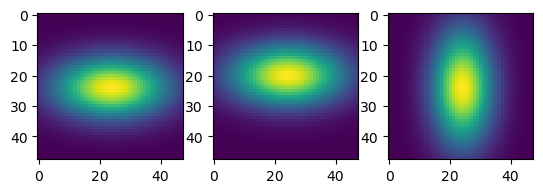

[Custom Weighted MSE Loss]: 4.141571


In [7]:
# Gaussian Functions: (TENSORFLOW)
print_example_guassian = YES
print_example_loss = YES

# mean_x, mean_y, cov_x, cov_y, theta
def generate_guassian(batch, image_shape):
    batch_size = batch.shape[0]
    batch = tf.expand_dims(tf.expand_dims(batch, axis=-1), axis=-1)
    x0, y0, sigma_x, sigma_y, theta = tf.cast(tf.unstack(batch, axis=-3), tf.float32)
    
    x_range = tf.range(start=0, limit=image_shape[0], delta=1)
    y_range = tf.range(start=0, limit=image_shape[1], delta=1)
    X_coord, Y_coord = tf.meshgrid(x_range, y_range, indexing='xy')
    X_coord = tf.cast(tf.expand_dims(X_coord, axis=0), tf.float32)
    Y_coord = tf.cast(tf.expand_dims(Y_coord, axis=0), tf.float32)
    
    X_coord = tf.tile(X_coord, [batch_size, 1, 1])
    Y_coord = tf.tile(Y_coord, [batch_size, 1, 1])
    
    a = tf.math.pow(tf.math.cos(theta), 2) / (2 * tf.math.pow(sigma_x, 2)) + tf.math.pow(tf.math.sin(theta), 2) / (2 * tf.math.pow(sigma_y, 2))
    b = -1 * tf.math.sin(theta) * tf.math.cos(theta) / (2 * tf.math.pow(sigma_x, 2)) + tf.math.sin(theta) * tf.math.cos(theta) / (2 * tf.math.pow(sigma_y, 2))
    c = tf.math.pow(tf.math.sin(theta), 2) / (2 * tf.math.pow(sigma_x, 2)) + tf.math.pow(tf.math.cos(theta), 2) / (2 * tf.math.pow(sigma_y, 2))

    img = tf.exp(-1 * (a * (X_coord - x0) ** 2 + 2 * b * (X_coord - x0) * (Y_coord - y0) + c * (Y_coord - y0) ** 2))

    return tf.expand_dims(img, axis=-1) # if (batch_size, height, width, channels)
    return tf.expand_dims(img, axis=1)  # if (batch_size, channels, height, width)

def custom_weighted_mse_loss(I, J, n):
  W = tf.pow(I, n)

  squared_diffs = tf.pow(I - J, 2)

  weighted_squared_diffs = W * squared_diffs

  loss = tf.reduce_mean(weighted_squared_diffs)

  return loss

if print_example_guassian:
    image_shape = (48, 48)
    batch = tf.convert_to_tensor([
        [24, 24, 13, 7, 0],
        [24, 20, 13, 7, 0],
        [24, 24, 13, 7, np.pi/2],
    ])

    generated_imgs = generate_guassian(batch, image_shape)
    for i in range(len(batch)):
        plt.subplot(1, len(batch), i + 1)
        plt.imshow(tf.squeeze(generated_imgs[i]))
    plt.show()

if print_example_loss:
    I = tf.random.normal((5, 1, 48, 48))
    J = tf.random.normal((5, 1, 48, 48))
    n = 2
    loss = custom_weighted_mse_loss(I, J, n)
    print("[Custom Weighted MSE Loss]:", loss.numpy())
    

In [8]:
# Model Architecture QAT
integer_bits = 2
fraction_bits = 6
symmetric = 0
keep_negative = 0

total_bits = integer_bits + fraction_bits
model = tf.keras.Sequential(
    [
        QConv2DBatchnorm(
            filters=6, kernel_size=5, strides=1, padding='valid',
            kernel_quantizer=f"quantized_bits({total_bits}, {0}, alpha=1)",
            bias_quantizer=f"quantized_bits({total_bits}, {0}, alpha=1)",
            kernel_initializer='lecun_uniform',
            kernel_regularizer=tf.keras.regularizers.l1(0.0001),
            use_bias=True,
        ),
       
        QActivation(f"quantized_relu({total_bits}, {integer_bits})"),
        
        tf.keras.layers.MaxPool2D(pool_size=4, strides=4),

        QConv2DBatchnorm(
            filters=16, kernel_size=5, strides=1, padding='valid',
            kernel_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
            bias_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
            kernel_initializer='lecun_uniform',
            kernel_regularizer=tf.keras.regularizers.l1(0.0001),
            use_bias=True,
        ),

        QActivation(f"quantized_relu({total_bits}, {integer_bits})"),
        
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

        tf.keras.layers.Flatten(),

        QDense(
            units=98,
            kernel_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
            bias_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
        ),
        
        QActivation(f"quantized_relu({total_bits}, {integer_bits})"),

        QDense(
            units=52,
            kernel_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
            bias_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
        ),
        QActivation(f"quantized_relu({total_bits}, {integer_bits})"),

        QDense(
            units=5,
            kernel_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
            bias_quantizer=f"quantized_bits({total_bits}, {integer_bits}, alpha=1)",
        )
    ]
)

# Compile the quantization-aware model
model.compile(optimizer='adam', loss=custom_weighted_mse_loss, run_eagerly=True)

In [9]:
# Training Loop
train_model = YES
save_model = YES
load_model = NO
Gaussian_Model_QAT_file = DATA_DIR + '/Models/[8]Gaussian_2I_6F.keras'

if train_model:
    num_epochs = 200
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    n = 1

    scaling_arr = np.array([48.0, 48.0, 24.0, 24.0, np.pi/2]).astype(np.float32)

    for epoch in range(num_epochs):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(dataset): 
            with tf.GradientTape() as tape:
                embedding = model(image_batch)
                unscaled_param = tf.constant(embedding * scaling_arr + 1e-8)
                final = generate_guassian(unscaled_param, (48,48))
                loss = custom_weighted_mse_loss(image_batch, final, n)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

if (save_model and not load_model):
    model.save(Gaussian_Model_QAT_file)

if (load_model):
    with tf.keras.utils.custom_object_scope({'custom_weighted_mse_loss': custom_weighted_mse_loss,
                                         'QConv2DBatchnorm': QConv2DBatchnorm,
                                         'QActivation': QActivation,
                                         'QDense': QDense
                                         }):
        model = tf.keras.models.load_model(Gaussian_Model_QAT_file)

model.summary()

  0%|          | 0/151 [00:00<?, ?it/s]2025-03-31 18:30:18.600012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-03-31 18:30:20.411817: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560d7643a410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-31 18:30:20.411850: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-03-31 18:30:20.411856: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-03-31 18:30:20.411860: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-03-31 18:30:20.411864: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-03-31 18:30:20.411868: I tensorfl

100%|██████████| 151/151 [00:12<00:00, 12.19it/s]


Epoch [1/200], Loss: 0.019207673070224508


100%|██████████| 151/151 [00:07<00:00, 20.26it/s]


Epoch [2/200], Loss: 0.004549579759627976


100%|██████████| 151/151 [00:07<00:00, 20.32it/s]


Epoch [3/200], Loss: 0.004432365267432683


100%|██████████| 151/151 [00:07<00:00, 20.38it/s]


Epoch [4/200], Loss: 0.004159074847197888


100%|██████████| 151/151 [00:07<00:00, 20.26it/s]


Epoch [5/200], Loss: 0.004360395227713103


100%|██████████| 151/151 [00:07<00:00, 20.36it/s]


Epoch [6/200], Loss: 0.00409622529879311


100%|██████████| 151/151 [00:07<00:00, 20.35it/s]


Epoch [7/200], Loss: 0.00404519548744506


100%|██████████| 151/151 [00:07<00:00, 20.35it/s]


Epoch [8/200], Loss: 0.0038807674893949007


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]


Epoch [9/200], Loss: 0.0038661818260586024


100%|██████████| 151/151 [00:07<00:00, 20.33it/s]


Epoch [10/200], Loss: 0.0039573341364423364


100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


Epoch [11/200], Loss: 0.0034668411495201042


100%|██████████| 151/151 [00:07<00:00, 20.42it/s]


Epoch [12/200], Loss: 0.003397674247351111


100%|██████████| 151/151 [00:07<00:00, 20.33it/s]


Epoch [13/200], Loss: 0.0033831699297991614


100%|██████████| 151/151 [00:07<00:00, 20.24it/s]


Epoch [14/200], Loss: 0.0033001474533476773


100%|██████████| 151/151 [00:07<00:00, 19.87it/s]


Epoch [15/200], Loss: 0.003375599109906925


100%|██████████| 151/151 [00:07<00:00, 20.27it/s]


Epoch [16/200], Loss: 0.0033456076488564937


100%|██████████| 151/151 [00:07<00:00, 20.32it/s]


Epoch [17/200], Loss: 0.0034242480028025954


100%|██████████| 151/151 [00:07<00:00, 20.05it/s]


Epoch [18/200], Loss: 0.0034607788871677705


100%|██████████| 151/151 [00:07<00:00, 20.05it/s]


Epoch [19/200], Loss: 0.0034012274619265896


100%|██████████| 151/151 [00:07<00:00, 20.23it/s]


Epoch [20/200], Loss: 0.0033430134575345265


100%|██████████| 151/151 [00:07<00:00, 20.27it/s]


Epoch [21/200], Loss: 0.0029655775989695693


100%|██████████| 151/151 [00:07<00:00, 20.20it/s]


Epoch [22/200], Loss: 0.002953813961762565


100%|██████████| 151/151 [00:07<00:00, 20.28it/s]


Epoch [23/200], Loss: 0.0029679501771507476


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]


Epoch [24/200], Loss: 0.002944903853750288


100%|██████████| 151/151 [00:07<00:00, 20.40it/s]


Epoch [25/200], Loss: 0.002976432872862117


100%|██████████| 151/151 [00:07<00:00, 20.25it/s]


Epoch [26/200], Loss: 0.0029667705368398634


100%|██████████| 151/151 [00:07<00:00, 20.32it/s]


Epoch [27/200], Loss: 0.002938573689674897


100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


Epoch [28/200], Loss: 0.002912261999761131


100%|██████████| 151/151 [00:07<00:00, 20.37it/s]


Epoch [29/200], Loss: 0.0029056793609202303


100%|██████████| 151/151 [00:07<00:00, 20.50it/s]


Epoch [30/200], Loss: 0.0029889336333838324


100%|██████████| 151/151 [00:07<00:00, 20.28it/s]


Epoch [31/200], Loss: 0.0027957042040833774


100%|██████████| 151/151 [00:07<00:00, 20.64it/s]


Epoch [32/200], Loss: 0.0026983048717509834


100%|██████████| 151/151 [00:07<00:00, 20.36it/s]


Epoch [33/200], Loss: 0.0026932178105270824


100%|██████████| 151/151 [00:07<00:00, 20.51it/s]


Epoch [34/200], Loss: 0.0026770185151859032


100%|██████████| 151/151 [00:07<00:00, 20.45it/s]


Epoch [35/200], Loss: 0.0026841441567197737


100%|██████████| 151/151 [00:07<00:00, 20.43it/s]


Epoch [36/200], Loss: 0.0026807882422149576


100%|██████████| 151/151 [00:07<00:00, 20.53it/s]


Epoch [37/200], Loss: 0.002720126114316926


100%|██████████| 151/151 [00:07<00:00, 20.40it/s]


Epoch [38/200], Loss: 0.0026733358513983275


100%|██████████| 151/151 [00:07<00:00, 20.30it/s]


Epoch [39/200], Loss: 0.002729883843058387


100%|██████████| 151/151 [00:07<00:00, 20.51it/s]


Epoch [40/200], Loss: 0.002702964065806163


100%|██████████| 151/151 [00:07<00:00, 20.33it/s]


Epoch [41/200], Loss: 0.0023983526429075083


100%|██████████| 151/151 [00:07<00:00, 20.56it/s]


Epoch [42/200], Loss: 0.0024008566994738107


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]


Epoch [43/200], Loss: 0.0024030638414601615


100%|██████████| 151/151 [00:07<00:00, 20.32it/s]


Epoch [44/200], Loss: 0.0023996603416143267


100%|██████████| 151/151 [00:07<00:00, 20.32it/s]


Epoch [45/200], Loss: 0.0023864655021504063


100%|██████████| 151/151 [00:07<00:00, 20.33it/s]


Epoch [46/200], Loss: 0.002389912555203927


100%|██████████| 151/151 [00:07<00:00, 20.30it/s]


Epoch [47/200], Loss: 0.002386082700817593


100%|██████████| 151/151 [00:07<00:00, 20.36it/s]


Epoch [48/200], Loss: 0.0024380812942611657


100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


Epoch [49/200], Loss: 0.0025076118532247494


100%|██████████| 151/151 [00:07<00:00, 20.59it/s]


Epoch [50/200], Loss: 0.0024144138712189254


100%|██████████| 151/151 [00:07<00:00, 20.53it/s]


Epoch [51/200], Loss: 0.0021462972254325816


100%|██████████| 151/151 [00:07<00:00, 20.48it/s]


Epoch [52/200], Loss: 0.0021492115249672275


100%|██████████| 151/151 [00:07<00:00, 20.42it/s]


Epoch [53/200], Loss: 0.002144237875395658


100%|██████████| 151/151 [00:07<00:00, 20.51it/s]


Epoch [54/200], Loss: 0.0021376759831528394


100%|██████████| 151/151 [00:07<00:00, 20.57it/s]


Epoch [55/200], Loss: 0.00216664012139108


100%|██████████| 151/151 [00:07<00:00, 20.60it/s]


Epoch [56/200], Loss: 0.00214762509097376


100%|██████████| 151/151 [00:07<00:00, 20.42it/s]


Epoch [57/200], Loss: 0.0021466103502678752


100%|██████████| 151/151 [00:07<00:00, 20.57it/s]


Epoch [58/200], Loss: 0.0021688796545915453


100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


Epoch [59/200], Loss: 0.0021401919279592915


100%|██████████| 151/151 [00:07<00:00, 20.73it/s]


Epoch [60/200], Loss: 0.0021213888104338915


100%|██████████| 151/151 [00:07<00:00, 20.60it/s]


Epoch [61/200], Loss: 0.0019330651821593279


100%|██████████| 151/151 [00:07<00:00, 20.54it/s]


Epoch [62/200], Loss: 0.0019396809523382428


100%|██████████| 151/151 [00:07<00:00, 20.53it/s]


Epoch [63/200], Loss: 0.0020190824342842233


100%|██████████| 151/151 [00:07<00:00, 20.38it/s]


Epoch [64/200], Loss: 0.00198762298758999


100%|██████████| 151/151 [00:07<00:00, 20.53it/s]


Epoch [65/200], Loss: 0.0019178413917057661


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]


Epoch [66/200], Loss: 0.0019137644885872669


100%|██████████| 151/151 [00:07<00:00, 20.37it/s]


Epoch [67/200], Loss: 0.0019218194535902597


100%|██████████| 151/151 [00:07<00:00, 20.40it/s]


Epoch [68/200], Loss: 0.001902885728096281


100%|██████████| 151/151 [00:07<00:00, 20.55it/s]


Epoch [69/200], Loss: 0.0019142880900115367


100%|██████████| 151/151 [00:07<00:00, 20.70it/s]


Epoch [70/200], Loss: 0.0019233390852340206


100%|██████████| 151/151 [00:07<00:00, 20.52it/s]


Epoch [71/200], Loss: 0.0017495805702930846


100%|██████████| 151/151 [00:07<00:00, 20.60it/s]


Epoch [72/200], Loss: 0.0017525712467594357


100%|██████████| 151/151 [00:07<00:00, 20.46it/s]


Epoch [73/200], Loss: 0.0017457161945235353


100%|██████████| 151/151 [00:07<00:00, 20.34it/s]


Epoch [74/200], Loss: 0.0017576109539310368


100%|██████████| 151/151 [00:07<00:00, 20.36it/s]


Epoch [75/200], Loss: 0.0017569728584232315


100%|██████████| 151/151 [00:07<00:00, 20.52it/s]


Epoch [76/200], Loss: 0.0017839964395944053


100%|██████████| 151/151 [00:07<00:00, 20.58it/s]


Epoch [77/200], Loss: 0.0017597845521144914


100%|██████████| 151/151 [00:07<00:00, 20.47it/s]


Epoch [78/200], Loss: 0.0017447462066428254


100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


Epoch [79/200], Loss: 0.0017754962576849275


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]


Epoch [80/200], Loss: 0.0017528693069895076


100%|██████████| 151/151 [00:07<00:00, 20.28it/s]


Epoch [81/200], Loss: 0.0015843188997654134


100%|██████████| 151/151 [00:07<00:00, 20.48it/s]


Epoch [82/200], Loss: 0.0015863322649792527


100%|██████████| 151/151 [00:07<00:00, 20.25it/s]


Epoch [83/200], Loss: 0.0015881054291489306


100%|██████████| 151/151 [00:07<00:00, 20.42it/s]


Epoch [84/200], Loss: 0.0015913042662332193


100%|██████████| 151/151 [00:07<00:00, 20.55it/s]


Epoch [85/200], Loss: 0.0015932484514493224


100%|██████████| 151/151 [00:07<00:00, 20.26it/s]


Epoch [86/200], Loss: 0.0015826233954088676


100%|██████████| 151/151 [00:07<00:00, 20.37it/s]


Epoch [87/200], Loss: 0.0015724561607391135


100%|██████████| 151/151 [00:07<00:00, 20.39it/s]


Epoch [88/200], Loss: 0.0015685385985867372


100%|██████████| 151/151 [00:07<00:00, 20.43it/s]


Epoch [89/200], Loss: 0.0015657854510088827


100%|██████████| 151/151 [00:07<00:00, 20.30it/s]


Epoch [90/200], Loss: 0.0015654242720874335


100%|██████████| 151/151 [00:07<00:00, 20.37it/s]


Epoch [91/200], Loss: 0.0014260596601872256


100%|██████████| 151/151 [00:07<00:00, 20.44it/s]


Epoch [92/200], Loss: 0.0014298645415596219


100%|██████████| 151/151 [00:07<00:00, 20.38it/s]


Epoch [93/200], Loss: 0.0014411318370307618


100%|██████████| 151/151 [00:07<00:00, 20.29it/s]


Epoch [94/200], Loss: 0.0014442398223643567


100%|██████████| 151/151 [00:07<00:00, 20.53it/s]


Epoch [95/200], Loss: 0.0014304416917190449


100%|██████████| 151/151 [00:07<00:00, 20.53it/s]


Epoch [96/200], Loss: 0.001435186492667737


100%|██████████| 151/151 [00:07<00:00, 20.37it/s]


Epoch [97/200], Loss: 0.0014308350891590316


100%|██████████| 151/151 [00:07<00:00, 20.37it/s]


Epoch [98/200], Loss: 0.0014350876352435212


100%|██████████| 151/151 [00:07<00:00, 20.43it/s]


Epoch [99/200], Loss: 0.0014305738423833784


100%|██████████| 151/151 [00:07<00:00, 20.62it/s]


Epoch [100/200], Loss: 0.001435635723975419


100%|██████████| 151/151 [00:07<00:00, 20.62it/s]


Epoch [101/200], Loss: 0.0013030367249635276


100%|██████████| 151/151 [00:07<00:00, 20.50it/s]


Epoch [102/200], Loss: 0.001313344642538454


100%|██████████| 151/151 [00:07<00:00, 20.38it/s]


Epoch [103/200], Loss: 0.001308689007245695


100%|██████████| 151/151 [00:07<00:00, 20.55it/s]


Epoch [104/200], Loss: 0.0012994201465306298


100%|██████████| 151/151 [00:07<00:00, 20.80it/s]


Epoch [105/200], Loss: 0.0012989225003263907


100%|██████████| 151/151 [00:07<00:00, 20.29it/s]


Epoch [106/200], Loss: 0.0013026169343968693


100%|██████████| 151/151 [00:07<00:00, 20.53it/s]


Epoch [107/200], Loss: 0.0013014963636828573


100%|██████████| 151/151 [00:07<00:00, 20.45it/s]


Epoch [108/200], Loss: 0.0013130887423870184


100%|██████████| 151/151 [00:07<00:00, 20.44it/s]


Epoch [109/200], Loss: 0.0013308484440311692


100%|██████████| 151/151 [00:07<00:00, 20.63it/s]


Epoch [110/200], Loss: 0.0013104211007066021


100%|██████████| 151/151 [00:07<00:00, 20.40it/s]


Epoch [111/200], Loss: 0.001199160853635199


100%|██████████| 151/151 [00:07<00:00, 20.61it/s]


Epoch [112/200], Loss: 0.00119615833441548


100%|██████████| 151/151 [00:07<00:00, 20.88it/s]


Epoch [113/200], Loss: 0.0011904421925470726


100%|██████████| 151/151 [00:07<00:00, 20.40it/s]


Epoch [114/200], Loss: 0.0011895364481918761


100%|██████████| 151/151 [00:07<00:00, 20.64it/s]


Epoch [115/200], Loss: 0.0011955732225273914


100%|██████████| 151/151 [00:07<00:00, 20.52it/s]


Epoch [116/200], Loss: 0.0011893717482661373


100%|██████████| 151/151 [00:07<00:00, 20.17it/s]


Epoch [117/200], Loss: 0.0011805924162922414


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]


Epoch [118/200], Loss: 0.0011847220894738737


100%|██████████| 151/151 [00:07<00:00, 20.36it/s]


Epoch [119/200], Loss: 0.0011859005209157206


100%|██████████| 151/151 [00:07<00:00, 20.47it/s]


Epoch [120/200], Loss: 0.0011863231370595612


100%|██████████| 151/151 [00:07<00:00, 20.59it/s]


Epoch [121/200], Loss: 0.0010837746949076948


100%|██████████| 151/151 [00:07<00:00, 20.58it/s]


Epoch [122/200], Loss: 0.0010866664345407031


100%|██████████| 151/151 [00:07<00:00, 20.17it/s]


Epoch [123/200], Loss: 0.0010833075788143456


100%|██████████| 151/151 [00:07<00:00, 20.47it/s]


Epoch [124/200], Loss: 0.001080385876498771


100%|██████████| 151/151 [00:07<00:00, 20.37it/s]


Epoch [125/200], Loss: 0.0010889517120239848


100%|██████████| 151/151 [00:07<00:00, 20.27it/s]


Epoch [126/200], Loss: 0.0011022466401390681


100%|██████████| 151/151 [00:07<00:00, 20.44it/s]


Epoch [127/200], Loss: 0.0011004185618598335


100%|██████████| 151/151 [00:07<00:00, 20.49it/s]


Epoch [128/200], Loss: 0.0011143024350880393


100%|██████████| 151/151 [00:07<00:00, 20.44it/s]


Epoch [129/200], Loss: 0.001088565268664812


100%|██████████| 151/151 [00:07<00:00, 20.57it/s]


Epoch [130/200], Loss: 0.0010962672454508527


100%|██████████| 151/151 [00:07<00:00, 20.43it/s]


Epoch [131/200], Loss: 0.0010007428693807135


100%|██████████| 151/151 [00:07<00:00, 20.50it/s]


Epoch [132/200], Loss: 0.0010080585153680911


100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


Epoch [133/200], Loss: 0.000994886972845859


100%|██████████| 151/151 [00:07<00:00, 20.34it/s]


Epoch [134/200], Loss: 0.0009897774800855593


100%|██████████| 151/151 [00:07<00:00, 20.36it/s]


Epoch [135/200], Loss: 0.000999326716309771


100%|██████████| 151/151 [00:07<00:00, 20.24it/s]


Epoch [136/200], Loss: 0.000997632900360873


100%|██████████| 151/151 [00:07<00:00, 20.47it/s]


Epoch [137/200], Loss: 0.0009905712182528728


100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


Epoch [138/200], Loss: 0.0009969683307753444


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]


Epoch [139/200], Loss: 0.0009979108612157947


100%|██████████| 151/151 [00:07<00:00, 20.40it/s]


Epoch [140/200], Loss: 0.001000097182977155


100%|██████████| 151/151 [00:07<00:00, 20.48it/s]


Epoch [141/200], Loss: 0.0009201276748262297


100%|██████████| 151/151 [00:07<00:00, 20.55it/s]


Epoch [142/200], Loss: 0.0009053970651627081


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]


Epoch [143/200], Loss: 0.0009009997654915941


100%|██████████| 151/151 [00:07<00:00, 20.44it/s]


Epoch [144/200], Loss: 0.0009034277519692253


100%|██████████| 151/151 [00:07<00:00, 20.39it/s]


Epoch [145/200], Loss: 0.0009067316712281167


100%|██████████| 151/151 [00:07<00:00, 20.38it/s]


Epoch [146/200], Loss: 0.0009041405333027195


100%|██████████| 151/151 [00:07<00:00, 20.51it/s]


Epoch [147/200], Loss: 0.0009018269707510457


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]


Epoch [148/200], Loss: 0.0009026461845997795


100%|██████████| 151/151 [00:07<00:00, 20.49it/s]


Epoch [149/200], Loss: 0.0009045233438870814


100%|██████████| 151/151 [00:07<00:00, 20.44it/s]


Epoch [150/200], Loss: 0.0009044793015037546


100%|██████████| 151/151 [00:07<00:00, 20.37it/s]


Epoch [151/200], Loss: 0.0008306483848371993


100%|██████████| 151/151 [00:07<00:00, 20.53it/s]


Epoch [152/200], Loss: 0.0008307745836718341


100%|██████████| 151/151 [00:07<00:00, 20.38it/s]


Epoch [153/200], Loss: 0.0008287953219795908


100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


Epoch [154/200], Loss: 0.0008318924213241514


100%|██████████| 151/151 [00:07<00:00, 20.55it/s]


Epoch [155/200], Loss: 0.0008407592609993472


100%|██████████| 151/151 [00:07<00:00, 20.50it/s]


Epoch [156/200], Loss: 0.0008460622398793352


100%|██████████| 151/151 [00:07<00:00, 20.75it/s]


Epoch [157/200], Loss: 0.0008402449276995234


100%|██████████| 151/151 [00:07<00:00, 20.43it/s]


Epoch [158/200], Loss: 0.0008401938333231586


100%|██████████| 151/151 [00:07<00:00, 20.58it/s]


Epoch [159/200], Loss: 0.0008335931678395102


100%|██████████| 151/151 [00:07<00:00, 20.29it/s]


Epoch [160/200], Loss: 0.0008348319833691152


100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


Epoch [161/200], Loss: 0.0007696271683582852


100%|██████████| 151/151 [00:07<00:00, 20.32it/s]


Epoch [162/200], Loss: 0.0007686472894155131


100%|██████████| 151/151 [00:07<00:00, 20.51it/s]


Epoch [163/200], Loss: 0.0007672560916263734


100%|██████████| 151/151 [00:07<00:00, 20.46it/s]


Epoch [164/200], Loss: 0.0007721116309152879


100%|██████████| 151/151 [00:07<00:00, 20.43it/s]


Epoch [165/200], Loss: 0.0007773465129997063


100%|██████████| 151/151 [00:07<00:00, 20.38it/s]


Epoch [166/200], Loss: 0.0007730090057027113


100%|██████████| 151/151 [00:07<00:00, 20.32it/s]


Epoch [167/200], Loss: 0.0007600127777164889


100%|██████████| 151/151 [00:07<00:00, 20.34it/s]


Epoch [168/200], Loss: 0.0007634752708339188


100%|██████████| 151/151 [00:07<00:00, 20.60it/s]


Epoch [169/200], Loss: 0.0007610726486336415


100%|██████████| 151/151 [00:07<00:00, 20.53it/s]


Epoch [170/200], Loss: 0.0007694048185629264


100%|██████████| 151/151 [00:07<00:00, 20.41it/s]


Epoch [171/200], Loss: 0.0007067915419924585


100%|██████████| 151/151 [00:07<00:00, 20.45it/s]


Epoch [172/200], Loss: 0.0007075062734753337


100%|██████████| 151/151 [00:07<00:00, 20.19it/s]


Epoch [173/200], Loss: 0.0007176918393179823


100%|██████████| 151/151 [00:07<00:00, 20.57it/s]


Epoch [174/200], Loss: 0.0007054084127102763


100%|██████████| 151/151 [00:07<00:00, 20.34it/s]


Epoch [175/200], Loss: 0.0007103518232092606


100%|██████████| 151/151 [00:07<00:00, 20.60it/s]


Epoch [176/200], Loss: 0.0007119706919762177


100%|██████████| 151/151 [00:07<00:00, 20.45it/s]


Epoch [177/200], Loss: 0.0007106942904878728


100%|██████████| 151/151 [00:07<00:00, 20.40it/s]


Epoch [178/200], Loss: 0.0007149499901940442


100%|██████████| 151/151 [00:07<00:00, 20.44it/s]


Epoch [179/200], Loss: 0.0007082315070079701


100%|██████████| 151/151 [00:07<00:00, 20.36it/s]


Epoch [180/200], Loss: 0.0007042336776476378


100%|██████████| 151/151 [00:07<00:00, 19.63it/s]


Epoch [181/200], Loss: 0.0006715189368735431


100%|██████████| 151/151 [00:07<00:00, 20.15it/s]


Epoch [182/200], Loss: 0.0006628415951295602


100%|██████████| 151/151 [00:07<00:00, 20.10it/s]


Epoch [183/200], Loss: 0.0006550300059938766


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]


Epoch [184/200], Loss: 0.0006483931577030496


100%|██████████| 151/151 [00:07<00:00, 20.25it/s]


Epoch [185/200], Loss: 0.0006599246508084139


100%|██████████| 151/151 [00:07<00:00, 20.21it/s]


Epoch [186/200], Loss: 0.0006462872835548459


100%|██████████| 151/151 [00:07<00:00, 20.26it/s]


Epoch [187/200], Loss: 0.0006462502904661888


100%|██████████| 151/151 [00:07<00:00, 20.34it/s]


Epoch [188/200], Loss: 0.0006414935931822421


100%|██████████| 151/151 [00:07<00:00, 20.37it/s]


Epoch [189/200], Loss: 0.0006429195748672926


100%|██████████| 151/151 [00:07<00:00, 20.60it/s]


Epoch [190/200], Loss: 0.0006417988781009288


100%|██████████| 151/151 [00:07<00:00, 20.51it/s]


Epoch [191/200], Loss: 0.0005951621419355421


100%|██████████| 151/151 [00:07<00:00, 20.30it/s]


Epoch [192/200], Loss: 0.0005911977866060094


100%|██████████| 151/151 [00:07<00:00, 20.43it/s]


Epoch [193/200], Loss: 0.0005945943389242108


100%|██████████| 151/151 [00:07<00:00, 20.46it/s]


Epoch [194/200], Loss: 0.0005935147163359485


100%|██████████| 151/151 [00:07<00:00, 20.43it/s]


Epoch [195/200], Loss: 0.0005968752122848042


100%|██████████| 151/151 [00:07<00:00, 20.14it/s]


Epoch [196/200], Loss: 0.0006038091378286481


100%|██████████| 151/151 [00:07<00:00, 20.25it/s]


Epoch [197/200], Loss: 0.0005893303703559896


100%|██████████| 151/151 [00:07<00:00, 20.40it/s]


Epoch [198/200], Loss: 0.0005919863415931333


100%|██████████| 151/151 [00:07<00:00, 20.29it/s]


Epoch [199/200], Loss: 0.0005924491356712895


100%|██████████| 151/151 [00:07<00:00, 20.31it/s]

Epoch [200/200], Loss: 0.0005909350453197512
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_conv2d_batchnorm (QConv2  (None, 44, 44, 6)         181       
 DBatchnorm)                                                     
                                                                 
 q_activation (QActivation)  (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 6)         0         
 D)                                                              
                                                                 
 q_conv2d_batchnorm_1 (QCon  (None, 7, 7, 16)          2481      
 v2DBatchnorm)                                                   
                                                                 
 q_activation_1 (QActivatio  (None, 7, 7, 16)          0         
 n)        


/home/pujan/miniconda3/envs/RHEED/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(
